# Domain Adversarial training of Neural Networks

This notebook walks through the implementation of DANN algorithm to adapt domain from MNIST to MNIST_M.
First, clone the git repository containing utils :

In [1]:
# !git clone https://github.com/vcoyette/DANN
%cd DANN

/content/DANN


 ## Dataset
 Download the MNIST_M dataset [here](https://drive.google.com/drive/folders/0B_tExHiYS-0vR2dNZEU4NGlSSW8), and place the archive in the data folder


In [ ]:
# !tar -xf data/mnist_m.tar.gz -C data/

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

from data.utils import load_source, load_target
from models import FeatureExtractor, Classifier, DomainRegressor
from test import testBaseLine, testDANN

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Dataset

Let's first load the MNIST dataset as the source domain and the MNIST_M dataset as the target domain.

In [ ]:
trainloader_source, testloader_source = load_source(batch_size=64,
                                                    shuffle=False,
                                                    num_workers=2)
trainloader_target, testloader_target = load_target(batch_size=64, 
                                                    shuffle=False, 
                                                    num_workers=2)

Let's plot some images:

Source Domain batch


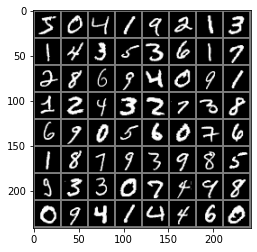

Target Domain batch


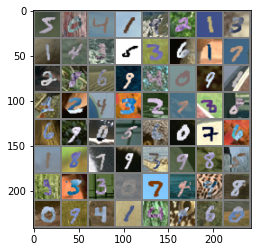

In [7]:

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images from source
dataiter = iter(trainloader_source)
images, labels = dataiter.next()

print('Source Domain batch')

# show images
imshow(torchvision.utils.make_grid(images))

# get some random training images from target
dataiter = iter(trainloader_target)
images, labels = dataiter.next()

print('Target Domain batch')

# show images
imshow(torchvision.utils.make_grid(images))



# Baseline

Let's consider as a baseline a network trained on the source domain only. To remain consistent with the DANN implementation, we will use the same components (feature extractor and classifier).

In [ ]:
class Net(nn.Module):
  def __init__(self, feature_extractor, classifier):
    super(Net, self).__init__()
    
    self.feature_extractor = feature_extractor
    self.classifier = classifier

  def forward(self, x):
    x = self.feature_extractor(x)
    x = self.classifier(x)

    return x

basenet = Net(FeatureExtractor(), Classifier()).to(device)

In [ ]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(basenet.parameters(), lr=0.001, momentum=0.9)

In [10]:
for epoch in range(10):

    print(f'Training epoch {epoch}...')

    for i, data in enumerate(trainloader_source):
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = basenet(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

print('Finished Training')

Training epoch 0...
Training epoch 1...
Training epoch 2...
Training epoch 3...
Training epoch 4...
Training epoch 5...
Training epoch 6...
Training epoch 7...
Training epoch 8...
Training epoch 9...
Finished Training


In [11]:
print(f'Accuracy on the source test images:'
      f'{testBaseLine(basenet, testloader_source)} %')

print(f'Accuracy on the target test images:'
      f'{testBaseLine(basenet, testloader_target)} %')

Accuracy on the source test images:98.45 %
Accuracy on the target test images:55.604932785246085 %


#DANN
Here is the general architecture of a DANN network :

![General Architecture](img/archi.png)

We will define 3 torch modules:
1. A feature Extractor (green)
1. A classifier (blue)
1. A Domain Regressor (pink)

We will use for each module the specific architecture defined for MNIST to MNIST_M transfer in the paper:

![Network Architecture](img/network.png)

The modules are defined in the file models.py.

Let's define our Gradient reversal layer : 
(discussion here: https://discuss.pytorch.org/t/solved-reverse-gradients-in-backward-pass/3589)

In [ ]:
class GradReverse(torch.autograd.Function):
    """
    Extension of grad reverse layer
    """
    @staticmethod
    def forward(ctx, x):
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        grad_output = grad_output.neg()
        return grad_output, None

    def grad_reverse(x):
        return GradReverse.apply(x)

We can now integrate all our modules in a single DANN network.

In [ ]:
class DANN(nn.Module):
    def __init__(self, feature_extractor, domain_regressor, classifier):
        super(DANN, self).__init__()

        self.feature_extractor = feature_extractor
        self.domain_regressor = domain_regressor
        self.classifier = classifier

    def forward(self, x):
        x = self.feature_extractor(x)
        y = GradReverse.grad_reverse(x)
        return self.classifier(x), self.domain_regressor(y)

net = DANN(FeatureExtractor(), DomainRegressor(), Classifier()).to(device)

Let's define training parameters:

In [ ]:
# Number of epochs
NUM_EPOCH = 100
# Length of an epoch
LEN_EPOCH = min(len(trainloader_source), len(trainloader_target))

total_steps = NUM_EPOCH * LEN_EPOCH


criterion_classifier = nn.NLLLoss()
criterion_domain_regressor = nn.NLLLoss()

We will use an SGD with a momentum of 0.9 and an adaptative learning rate as follow:
$$
\mu_p = \frac{\mu_0}{(1+\alpha \cdot p)^\beta}
$$
With:
$$
\mu_0 = 0.01\\
\alpha = 10\\
\beta = 0.75\\
p \text{ is the training progress linearly changing from 0 to 1}
$$

As stated in the paper, the domain adaptation parameter will be set only for the feature extractor to:
$$
\lambda_p = \frac{2}{1 + e^{-\gamma \cdot p}} - 1
$$
with
$$
\gamma = 10
$$

In order to set the regularization parameter only for the feature extractor, we will define a virtual learning rate of $\mu_p / \lambda_p$ on the domain regressor.



In [ ]:

alpha = 10
beta = 0.75
gamma = 10
mu0 = 0.01
eta = 0.9

# Total number of timesteps

optimizer = optim.SGD([{'params': net.feature_extractor.parameters()},
                       {'params': net.classifier.parameters()},
                       {'params': net.domain_regressor.parameters()}], 
                       lr = mu0,
                       momentum = eta)
mu_p = lambda step: 1 / (1 + alpha * step / total_steps) ** beta

def domain_regressor_lr_scheduler(step):
    if step == 0:
        lambda_p = 1
    else:
        p = step / total_steps
        lambda_p = 2 / (1 + np.exp(-gamma * p)) - 1

    return mu_p(step)/lambda_p
  
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [mu_p, mu_p, domain_regressor_lr_scheduler])


In [16]:
# Initialize progress
p = 0

labels_domain_source = torch.zeros(64).long().to(device)
labels_domain_target = torch.ones(64).long().to(device)

for epoch in range(NUM_EPOCH):

    print(f'Training epoch {epoch}...')

    for data_source, data_target in zip(trainloader_source, trainloader_target):
          
        # Update progress   
        p += 1 / total_steps

        # Compute the regularization term
        lambda_p = 2 / (1 + np.exp(-gamma * p)) - 1

        # Ensure batch for source and target has same lenght
        batch_size = min((data_source[0].shape[0], data_target[0].shape[0]))

        data_source = data_source[0][:batch_size], data_source[1][:batch_size]
        data_target = data_target[0][:batch_size], data_target[1][:batch_size]
        labels_domain = torch.cat((labels_domain_source[:batch_size], 
                                   labels_domain_target[:batch_size]))


        # Split and transfer to GPU
        image_source, labels_source = data_source[0].to(device), data_source[1].to(device)
        image_taget, labels_target = data_target[0].to(device), data_target[1].to(device)

        # Source forward pass
        src_class, src_domain = net(image_source)

        # Classifier loss
        class_loss = criterion_classifier(src_class, labels_source)

        # Target forward pass
        _, tgt_domain = net(image_taget)

        # Domain Loss
        preds_domain = torch.cat((src_domain, tgt_domain))
        domain_loss = criterion_domain_regressor(preds_domain, labels_domain)

        # Total loss
        loss = class_loss + lambda_p * domain_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    print('Testing...')
    print(f'Accuracy on source test dataset: {testDANN(net, trainloader_source)} %')
    print(f'Accuracy on taget test dataset: {testDANN(net, trainloader_target)} %')

print('Finished Training')

Training epoch 0...
Testing...
Accuracy on source test dataset: 98.225 %
Accuracy on taget test dataset: 59.30238470534398 %
Training epoch 1...
Testing...
Accuracy on source test dataset: 98.87 %
Accuracy on taget test dataset: 62.03115201437264 %
Training epoch 2...
Testing...
Accuracy on source test dataset: 98.98166666666667 %
Accuracy on taget test dataset: 61.922679276622425 %
Training epoch 3...
Testing...
Accuracy on source test dataset: 98.97333333333333 %
Accuracy on taget test dataset: 62.75317367502245 %
Training epoch 4...
Testing...
Accuracy on source test dataset: 98.985 %
Accuracy on taget test dataset: 62.19047134794325 %
Training epoch 5...
Testing...
Accuracy on source test dataset: 98.465 %
Accuracy on taget test dataset: 62.488771376756326 %
Training epoch 6...
Testing...
Accuracy on source test dataset: 98.09 %
Accuracy on taget test dataset: 60.43117913255708 %
Training epoch 7...
Testing...
Accuracy on source test dataset: 98.465 %
Accuracy on taget test dataset